In [48]:
### New version created to adapt from 230817_CACloudKT_v3.ipynb ###
### two weeks before qualifying exam. Intention: clean up       ###
## data and generally get a simplest, coarsest working model    ###

from multiprocessing import Pool
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from scipy.interpolate import interp1d

from dustmaps.bayestar import BayestarQuery
from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm

import emcee
import corner

In [49]:
### Load in CA Cloud Summary Data 
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

In [50]:
### Edenhofer Dustmap Coordinates ###
distance = np.linspace(0, 800, 800)


l0, b0 = (163., -8.0)
l_ = np.linspace(l0 - 9., l0 + 9., 800)
b_ = np.linspace(b0 - 9., b0 + 9., 800)
l, b, d = np.meshgrid(l_, b_, distance)
print(l.shape)

coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=distance*u.pc, frame='galactic')
# edenhoferquery = Edenhofer2023Query()
# edenhofer = edenhoferquery(coords) * 2.658 # https://zenodo.org/record/7811871

(800, 800, 800)


In [51]:
### Get the edenhofer dustmap from prepped file rather than reading in ###

import h5py
with h5py.File('edenhofer_out.h5', 'r') as f:
    edenhofer = np.array(f['data'])

In [52]:
### Vergely dustmap coordinates (probably not used)
distance_vergely = np.linspace(0, 1000, 200)

l0, b0 = (163., -8.0)
l_vergely_ = np.linspace(l0 - 9., l0 + 9., 200)
b_vergely_ = np.linspace(b0 - 9., b0 + 9., 200)
l_vergely, b_vergely, d_vergely = np.meshgrid(l_vergely_, b_vergely_, distance_vergely)
print(l_vergely.shape)

# coords_vergely = SkyCoord(l_vergely*u.deg, b_vergely*u.deg,
#                   distance=distance_vergely*u.pc, frame='galactic')

# vergelyquery = Vergely2022Query()
# vergely = vergelyquery(coords_vergely)

(200, 200, 200)


In [53]:
lambda0 = 15272.42 
sigma0 = 1.15

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
window_inds = np.where(window)[0]
wavs_window = wavs[window]
window_mask = (wavs_window < lambda0) - 5 | (wavs_window > lambda0 + 5)

def resample_interp(data, rv, resample_wavelengths = wavs, hdu_sel = None):
    wavs_rv = get_wavs(rv = rv, hdulist = hdu_sel)
    interp = interp1d(wavs_rv, data, kind = 'slinear', bounds_error = False)
    
    data_interp = interp(resample_wavelengths)
    
    return data_interp

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

In [54]:
def get_ca_res(fname):
    return str(CAresdir + str(fname))

def get_madgics_res(fname):
    return str(CAMADGICSresdir) + str(fname)

def select_stars(tab, l0, b0, radius = 1):
    cond = np.sqrt((tab['GLON'] - l0)**2 + (tab['GLAT'] - b0)**2) < radius
    return np.where(cond)[0]

In [55]:
### Let's make some quality cuts on CA_meta! ADDED 09/28/2023, old selection might be weird ###

lambda0 = 15272.42 
sigma0 = 1.15

from scipy.optimize import curve_fit
def gauss_model(x, mu, sigma, amp):
    return 1 - amp * np.exp(-(x-mu)**2/(2 * sigma0))

def chi2(signal, model):
    return np.nansum((signal - model)**2 / model)

chi2_array = np.zeros(len(CA_meta))
for i in range(len(CA_meta)):
    star = CA_meta[i]
    reshdul = fits.open(get_ca_res(star['FILE']))
    res = reshdul[1].data[window]
    fit, cov = curve_fit(gauss_model, wavs[window], res, p0 = (lambda0, sigma0, 0.03), check_finite = False)
    err = np.sqrt(np.diag(cov))
    chi2_val = chi2(res, gauss_model(wavs[window], *fit))
    chi2_array[i] = chi2_val


CA_meta_full = CA_meta.copy()
with open('goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)
CA_meta = CA_meta[goodbad]
print(len(CA_meta))

# CA_filter = (CA_meta['SNR'] > 70) & (chi2_array < 1/70)
# CA_meta = CA_meta[CA_filter]


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


790


In [56]:
mhdul = fits.open(get_madgics_res(CA_meta['FILE'][0]))
mwavs = get_wavs(hdulist = mhdul) #same from [125:]
mwindow = (mwavs > lambda0 - 9) & (mwavs < lambda0 + 9)
mwavs_window = mwavs[mwindow]

In [57]:
def find_nearest(ll, bb, l_sel = l_, b_sel = b_):

    return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

def find_nearest_dist(d):
    return np.argmin(np.abs(distance[:, np.newaxis] - d), axis = 0)


def dAV_dd(l0, b0, bin_edges):
    l_ind, b_ind = find_nearest(l0, b0)
    sightline = np.copy(edenhofer[b_ind, l_ind, :]) #needs to be b then l then :

    d_min, d_max = bin_edges

    extinction = sightline[(distance > d_min) & (distance < d_max)]
    return np.sum(extinction )

def dAV_dd_star(l0, b0, bin_edges, distances):
    l_ind, b_ind = find_nearest(l0, b0)
    d_min, d_max = bin_edges
    sightline = np.copy(edenhofer[b_ind, l_ind, :])
    sightline[(distance < d_min) | (distance > d_max)] = 0
    sightline_av = (np.cumsum(sightline)) 
    d_ind = find_nearest_dist(distances)

    return np.nanmedian(sightline_av[d_ind])

def Differential_Amplitude(dAv_dd, dd = 1):
    if type(dd) == int:
        return  0.024 * dAv_dd * dd  # 1/(np.sqrt(2 * np.pi) * sigma0) * 102e-3 * dAv_dd * dd
    elif dd.shape == dAv_dd.shape:
        return 0.024 * dAv_dd * dd 
    else:
        return 0.024 * dAv_dd * dd[np.newaxis, :]

        #  return 0.024 * dAv_dd * dd[:, np.newaxis]

def dAV_dd_array(l, b, bins, star_dist, dmap_dist = distance):
    l_ind, b_ind = find_nearest(l, b)
    verg_sightline = np.copy(edenhofer[b_ind, l_ind, :]) 
    dAVdd = np.zeros(len(bins)-1)
    dAVdd_all = np.zeros(len(bins)-1)
    dAVdd_mask = np.zeros(len(bins-1))
    for i in range(len(dAVdd)):
        bin_min, bin_max = bins[i], bins[i+1]
        if bin_min < star_dist:
            dist_max = bin_max
            if bin_max >= star_dist:
                dist_max = star_dist
        else:
            dist_max = -np.inf

            
        dAVdd[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= dist_max)])

        dAVdd_all[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= bin_max)])

    dAVdd_mask = (dAVdd == 0).astype(bool)
    return dAVdd, dAVdd_all, dAVdd_mask

In [58]:
ds = 2.5 # x downsampled
rad = 0.23
sample_dim_l = np.linspace(159, 167, int(8 / (ds * rad)))
sample_dim_b = np.linspace(-12.5 , -4.5, int(8 / (ds * rad)))
sample_grid_l, sample_grid_b = np.meshgrid(sample_dim_l, sample_dim_b)
grid_map_inds = np.array([find_nearest(sample_grid_l.flatten()[i], sample_grid_b.flatten()[i]) for i in range(len(sample_grid_l.flatten()))]).T
grid_map = np.nansum(np.copy(edenhofer[grid_map_inds[1], grid_map_inds[0], :]).reshape(*sample_grid_l.shape, -1), axis = 2)
grid_Nstar = np.array([np.nansum((np.abs((sample_grid_l.flatten()[i] - CA_meta['GLON'])) <= rad) & 
            (np.abs((sample_grid_b.flatten()[i] - CA_meta['GLAT'])) <= rad)) for i in range(len(sample_grid_l.flatten()))]).reshape(*sample_grid_l.shape)

filament_l = (159, 169)
filament_b = (-10, -6)

crit_filament = ((sample_grid_l > filament_l[0]) & (sample_grid_l < filament_l[1]) & 
                 (sample_grid_b > filament_b[0]) & (sample_grid_b < filament_b[1]) &
                 (grid_map > 2.2) & (grid_Nstar > 5) & (grid_Nstar <= 10))

crit_background =  (((sample_grid_l <= filament_l[0]) | (sample_grid_l >= filament_l[1]) |
                 (sample_grid_b <= filament_b[0]) | (sample_grid_b >= filament_b[1])) &
                 (grid_map <= 1.5) & (grid_Nstar > 5) & (grid_Nstar <= 10))

# crit_coverage = (np.sum() => 1 & )

N_filament = np.sum(crit_filament)
N_background = np.sum(crit_background)
print(np.sum(crit_filament))
print(np.sum(crit_background))

9
2


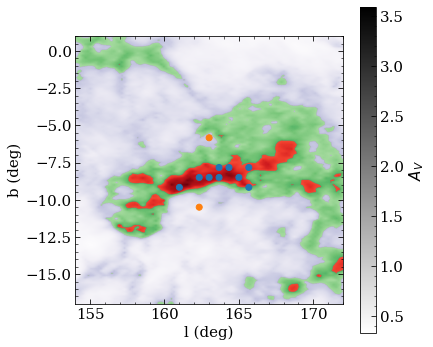

In [59]:
fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
# ax.scatter(CA_meta['GLON'], CA_meta['GLAT'], marker = '.')

masks = (np.nansum(edenhofer, axis = 2) >= 2.2).astype(float)
masks_2 = ((np.nansum(edenhofer, axis = 2) >= 1.5) & (np.nansum(edenhofer, axis = 2) < 2.2)).astype(float)
masks_3 = (np.nansum(edenhofer, axis = 2) < 1.5).astype(float)
im_mask = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Reds', alpha = masks, extent = (l0-9, l0+9, b0-9, b0+9))
im_mask_2 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Greens', alpha = masks_2, extent = (l0-9, l0+9, b0-9, b0+9))
im_mask_3 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Purples', alpha = masks_3, extent = (l0-9, l0+9, b0-9, b0+9))


ax.scatter(sample_grid_l, sample_grid_b, alpha = (crit_filament).astype(float), vmin = 0, vmax = 8)
ax.scatter(sample_grid_l, sample_grid_b, alpha = (crit_background).astype(float), vmin = 0, vmax = 8)

fig.colorbar(im, label = '$A_V$')

plt.show()

In [60]:
l_fil, b_fil, AV_fil = (sample_grid_l[crit_filament].flatten(), sample_grid_b[crit_filament].flatten(),
                        grid_map[crit_filament].flatten())
l_off, b_off, AV_off = (sample_grid_l[crit_background].flatten(), sample_grid_b[crit_background].flatten(),
                        grid_map[crit_background].flatten())

l_sample, b_sample, AV_sample = (np.concatenate([l_fil, l_off]), np.concatenate([b_fil, b_off]),
                                  np.concatenate([AV_fil, AV_off]))

selected_inds = []
for i in range(len(l_sample)):
    l_center, b_center = l_sample[i], b_sample[i]
    selection = select_stars(CA_meta, l_center, b_center, radius = rad)
    print(len(selection))
    selected_inds.append(selection)



4
4
6
7
7
6
5
4
4
5
5


In [61]:
# def find_nearest_v (ll, bb, l_sel = l_vergely_, b_sel = b_vergely_):

#     return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

# def find_nearest_dist_v (d):
#     return np.argmin(np.abs(distance_vergely[:, np.newaxis] - d), axis = 0)

# def dAV_dd_array_v(l, b, bins, star_dist, dmap_dist = distance_vergely):
#     l_ind, b_ind = find_nearest_v(l, b)
#     verg_sightline = np.copy(vergely[b_ind, l_ind, :]) 
#     dAVdd = np.zeros(len(bins)-1)
#     dAVdd_all = np.zeros(len(bins)-1)
#     dAVdd_mask = np.zeros(len(bins-1))
#     for i in range(len(dAVdd)):
#         bin_min, bin_max = bins[i], bins[i+1]
#         if bin_min < star_dist:
#             dist_max = bin_max
#             if bin_max >= star_dist:
#                 dist_max = star_dist
#         else:
#             dist_max = -np.inf

            
#         dAVdd[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= dist_max)])

#         dAVdd_all[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= bin_max)])

#     dAVdd_mask = (dAVdd == 0).astype(bool)
#     return dAVdd, dAVdd_all, dAVdd_mask

In [62]:
class sightline:
    ### Container object for stars, sightline dAV_dd, velocity, and spaxel assignment.
    def __init__(self, stars, bins = None, **kwargs):
        self.stars = stars
        dist = self.stars['DIST']

        if bins is not None:
            h = np.histogram(dist, bins)[0]
            self.bins = np.insert(bins[1:][h != 0], 0, bins[0])
            self.bin_inds = np.digitize(dist, bins)
        else:
            self.make_bins()
            self.bin_inds = np.digitize(dist, self.bins)  
        self.rvelo = np.zeros(len(self.bins) - 1)
        self.get_DIBs(**kwargs)
        self.init_signals = self.model_signals(self.rvelo, self.dAVdd)
        self.ndim = len(self.voxel_dAVdd)
        self.nsig = len(self.stars)
        
    def make_bins(self, binsep = 10, dmin = 0):
        ### Assigns stars to distance bins if bins are not already supplied.
        dist = self.stars['DIST']
        bins = np.sort(np.insert(np.delete(dist, np.where(dist <= dmin)[0]), 0, dmin))

        i = 0
        while i >= 0:
            try:
                next_bin = np.min(bins[bins > bins[i]])
            except:
                print('broke:')
                print(bins[bins > bins[i]])
                print(len(self.stars))

            bins[i+1] = np.max([next_bin, bins[i] + binsep]) + 0.01
            if bins[i+1] >= np.max(dist):
                bins = bins[:i+2]
                i = -np.inf
            i = i+1
        
        self.bins = bins
            
    def get_DIBs(self, MADGICS = False):
        signals = np.zeros((len(self.stars), len(wavs_window)))
        signal_errs = np.zeros((len(self.stars), len(wavs_window)))
        dAVdd = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_all = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_mask =np.zeros((len(self.stars), len(self.bins)-1)).astype(bool)
        # dAVdd_v = np.zeros((len(self.stars), len(self.bins)-1))
        # print(len(dAVdd_all))
        if MADGICS:
            signals_aspcap = np.zeros((len(self.stars), len(wavs_window)))
            signal_errs_aspcap = np.zeros((len(self.stars), len(wavs_window)))


        # dAVdd = np.zeros(len(self.bins))

        for i in range(len(self.stars)):
            star = self.stars[i]
            res_hdul = fits.open(get_ca_res(star['FILE']))
            signals[i, :] = res_hdul[1].data[window]
            signal_errs[i, :] = res_hdul[2].data[window]
            l, b = star['GLON'], star['GLAT']
            dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'])
            # dAVdd_v[i], _, __ = dAV_dd_array_v(l, b, self.bins, star['DIST'])


            if MADGICS:
                signals_aspcap[i, :] = np.copy(signals[i, :])
                signal_errs_aspcap[i, :] = np.copy(signal_errs[i, :])
                res_hdul_m = fits.open(get_madgics_res(star['FILE']))
                signals[i, :] = res_hdul_m[1].data[0, 125:][window]
                # signal_errs[i, :] = res_hdul_m[5].data[0, 125:][window]
                # print(res_hdul[2].data.shape)
                # errs = resample_interp(res_hdul[2].data, rv = - star['VHELIO_AVG'])
                # # if 
                # errs = resample_interp(errs, rv = np.median(res_hdul_m[3].data['MADGICS_VBARY']))
                # signal_errs[i, :] = errs[window]



        self.signals = signals
        self.signal_errs = signal_errs
        self.dAVdd = dAVdd
        self.voxel_dAVdd = np.nanmedian(dAVdd_all, axis = 0)
        self.voxel_dAVdd_std = np.nanstd(dAVdd_all, axis = 0, ddof = 1)
        self.dAVdd_mask = dAVdd_mask.astype(bool)
        # self.dAVdd_v = dAVdd_v
        if MADGICS:
            self.signals_aspcap = signals_aspcap
            self.signal_errs_aspcap = signal_errs_aspcap
        # print(self.voxel_dAVdd.shape)
        # self.dAVdd = dAV_dd_array(np.median(self.stars['GLON']), np.median(self.stars['GLAT']), 
        #                           self.bins, np.max(self.bins))

    def model_signals(self, rvelo, dAVdd = None):
        if dAVdd is None:
            dAVdd = self.dAVdd
        # print('dAVdd shape: ', dAVdd.shape)
        # dAVdd[self.dAVdd_mask] = 0
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(self.bins) - 1, 1))
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = Differential_Amplitude(dAVdd, self.bins[1:]-self.bins[:-1])

        def single_signal(amp, bindex):
            amp[bindex :] = 0 # THIS MIGHT NEED TO BE -1

            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)
            return summed_DIB  + 1


        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = dAVdd[i, :]
            # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
            amp = Differential_Amplitude(dAVdd_star, 1)

            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp, bin_index)
        return signals
    
    # def intake_full(self, sampler_full):
    #     self.sampler_full = sampler_full
  
    def intake(self, sampler):
        self.sampler = sampler

        samples = sampler.chain[:, int(sampler.chain.shape[1]/2):, :].reshape((-1, sampler.chain.shape[-1]))

        medians = np.nanmedian(samples[:, :], axis = 0)


        med_dAV_dd = medians[len(self.bins)-1:].reshape(-1, len(self.bins)-1)
        self.dAV_dd_derived = med_dAV_dd


    def intake_coords(self, l, b, AV = None):
        self.l = l
        self.b = b
        self.AV = AV


In [63]:
sightlines = []
for i in range(len(selected_inds)):
    indx = selected_inds[i]
    sightlines.append(sightline(CA_meta[indx], MADGICS = False))
    sightlines[i].intake_coords(l_sample, b_sample, AV = AV_sample)

In [64]:
len(sightlines)

11

In [65]:
# fig, ax = plt.subplots()
# for i in range(len(sightlines[1].dAVdd)):
#     ax.plot(sightlines[1].dAVdd[i, :], color = 'C'+str(i))
#     # ax.plot(sightlines[1].dAVdd_v[i, :]* 5, color = 'C'+str(i), linestyle = 'dashed')

In [66]:
from matplotlib.backends.backend_pdf import PdfPages
if False:
    # with PdfPages('Temp/Sightlines_plots_a.pdf') as pdf:
    for sl in sightlines:
        fig, ax = plt.subplots(figsize = (8, 16))
        d_order = np.argsort(sl.stars['DIST'])
        for j in range(len(d_order)):
            ii = d_order[j]
            ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * j, color = 'C{}'.format(j))

        plt.show()

if False:
    # with PdfPages('Temp/Sightlines_plots_a.pdf') as pdf:
    for i in range(len(sightlines)):
        sl_i = sightlines[i]
        nvel = len(sl_i.bins)-1
        fig, ax = plt.subplots(figsize = (16, 6))
        for j in range(nvel):
            chain_j = sl_i.sampler.chain[:, :, j].T
            ax.plot(chain_j+ j * 50)
        plt.show()

In [67]:
# chain = sl_i.sampler.chain[:, :, 3].T
# plt.plot(chain)

In [68]:
# model_signals(self, rvelo, dAVdd = None):
sl = sightlines[0]
signals = np.zeros(sl.signals.shape)
signal_errs = np.zeros(sl.signals.shape)
def loglikely_2(v, av, sl = sl, **kwargs):

    # v = p[:int(len(p)/2)]
    # av = p[int(len(p)/2):]
    # av = np.tile(av, len(sl.stars)).reshape(len(sl.stars), -1)

    signal = sl.signals
    sigma = sl.signal_errs

    # print('loglikely av shape' ,av.shape)
    val = - 0.5 * np.nansum((signal - sl.model_signals(v, dAVdd = av))**2 / (sigma**2)) # IS THIS WRONG
    if np.isnan(val):
        # print('fail loglikely')
        return -np.inf
    else:
        return val
    # return - 0.5 * np.sum((signal - sl.model_signals(v, dAVdd = av))**2 / (sigma**2)) 

def logprior_v(v, v_max = 5, prior_mult = 1, **kwargs):
    if (np.any(np.abs(v) > prior_mult * v_max)):
        # print('logprior v -inf')
        return -np.inf
    return 0.0

def logprior_davdd(av, AV_base = 5, AV_max = 10):   
    # if (np.any(np.abs(av - AV_base) > AV_max)):
    #     # print('av -inf')
    #     return -np.inf
    if ((np.any(av < 0))):
        # print('logprior av -inf')
        return -np.inf
    return 0.0

def logprior_davdd_reg(av,sl, mask = None, **kwargs):
    # print(av.shape)
    # av = np.tile(av, len(sl.stars)).reshape(len(sl.stars), -1) # FOR NOW 
    av = np.copy(av)
    mask = sl.dAVdd_mask
    # mask = av == 0
    av[mask] = np.nan

    # avmed = np.nanmedian(av, axis = 0)
    # avstd = np.nanstd(av, ddof = 1,  axis = 0)
    # avstd[np.isnan(avstd)] = 0.2

    avmed = sl.voxel_dAVdd
    # print(avmed.shape)
    avstd = sl.voxel_dAVdd_std * 15 # should be 10
    # print(avstd.shape)

    # print(av.shape)
    # return 0.0
    # lp_val = np.nansum(np.log(1/(np.sqrt(2 * np.pi) * avstd))) - 0.5 * np.nansum((av - avmed[:, np.newaxis])**2 / (2 * avstd[:, np.newaxis]**2))# first part might not be needed
    # lp_val = np.nansum(- 0.5 * np.nansum((av - avmed[np.newaxis, :])**2 / (2 * avstd[np.newaxis, :]**2)))# first part might not be needed
    lp_val = -np.nansum(np.log(np.sqrt(2 * np.pi))) + np.nansum(- 0.5 * np.nansum((av - avmed)**2 / (2 * avstd**2)))# first part might not be needed

    
    return lp_val
    # return np.sum(np.log(1/(avstd[:, np.newaxis] * np.sqrt(2 * np.pi ))) - 0.5 * (av - avmed[:, np.newaxis])**2 / (2 * avstd[:, np.newaxis]**2)) # first part might not be needed

def logprob_2(p, sl = sl, logprior = logprior_v, loglikely = loglikely_2, **kwargs):
    ndim = len(sl.voxel_dAVdd)
    v = p[ :ndim]
    av = p[ndim:].reshape(-1, ndim)

    # print(av.shape)

    lp = logprior(v, **kwargs)
    lp_davdd = logprior_davdd(av, AV_base = sl.dAVdd)
    lp_davdd_reg = logprior_davdd_reg(av, sl, **kwargs)

    if (not np.isfinite(lp)) | (not np.isfinite(lp_davdd)) | (not np.isfinite(lp_davdd_reg)):
        # print('fail logprob')
        return -np.inf
    return lp + lp_davdd + lp_davdd_reg + loglikely_2(v, av, sl = sl, **kwargs)

def logprob_avfix(p, av = None, sl = sl, logprior = logprior_v, loglikely = loglikely_2, **kwargs):
    ndim = len(sl.voxel_dAVdd)
    v = p[:ndim]

    # av = av.reshape(-1, ndim)

    lp = logprior(v, **kwargs)
    if (not np.isfinite(lp)):
        return -np.inf
    return lp + loglikely_2(v, av, sl = sl, **kwargs)



In [69]:
import time

In [70]:

def MCMC(sl, steps = 1000, nwalkers = 100):
    ndim = len(sl.voxel_dAVdd) 
    ndim_amp = int(2 * ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, 
                                    kwargs={'sl': sl, 'prior_mult':  3, 'v_max': 5, 'sigma': signal_errs})
    init = 7.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
  
    init[:, ndim:] = np.abs(sl.voxel_dAVdd[np.newaxis, :] + 0.5*(np.random.random(init[:, ndim:].shape)-0.5))
    print(init.shape)
    sampler.run_mcmc(init,  steps);
    
    return sampler, ndim, ndim_amp


def MCMC_scary(sl, steps = 1000, nwalkers = 100, pool = None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)
    ndim_amp = int(ndim + ndim * nstar)
    

    # dAVdd_prior = sl.dAVdd[:]
    # dAVdd_prior[dAVdd_prior == 0] = np.nan 
    # dAVdd_prior_med = np.nanmedian(dAVdd_prior, axis = 1)
    # dAVdd_prior_std = np.nanstd(dAVdd_prior, axis = 1, ddof = 1)
    # gaussparams = (dAVdd_prior_med, dAVdd_prior_std)
    # print(gaussparams)

    # with Pool(15) as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, 
                                    kwargs={'sl': sl,  'prior_mult':  1, 'v_max': 20, 'sigma': signal_errs}, pool = pool)
    init = 12.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)

    init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    print('NDIM:', ndim, 'NSTAR:', nstar, 'INITSHAPE:', init.shape)
    
    sampler.run_mcmc(init,  steps, progress = True);
    
    return sampler, ndim, ndim_amp

def MCMC_vonly(sl, sampler_previous, steps = 1000, nwalkers = 100, pool = None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)

    samples = sampler_previous.chain[:, 200:, :].reshape((-1, sampler_previous.chain.shape[-1]))
    medians = np.nanmedian(samples[50:, :], axis = 0)
    av = medians[ndim:].reshape(-1, ndim)
    
    # with Pool(15) as pool:

    sampler = emcee.EnsembleSampler(nwalkers , ndim, logprob_avfix, 
                                    kwargs={'sl': sl,  'prior_mult':  4, 'v_max': 5, 'sigma': signal_errs}, pool = pool) 
    init = 12.5 *(np.random.random((nwalkers, ndim)) - 0.5)

    # init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    print('NDIM:', ndim, 'NSTAR:', nstar, 'AVFIXED')
    
    sampler.run_mcmc(init,  steps, progress = True );
    
    return sampler, ndim


In [71]:
stp = 2000
# sampler, ndim, ndim_amp = MCMC_scary(a, steps = stp, nwalkers = 500)
# sampler1, ndim1, ndim_amp1 = MCMC(a1, steps = stp)
# sampler2, ndim2, ndim_amp2 = MCMC(a2, steps = stp)
# sampler3, ndim3, ndim_amp3 = MCMC(a3, steps = stp)

run_label = '1002c'
save_individual = False

if True:
    if not os.path.exists(os.getcwd() + '/RUNS/' + run_label):
        os.makedirs(os.getcwd() +'/RUNS/' + run_label)
    with Pool(20) as pool:
        for i in range(len(sightlines)):
            try:
                sl_i = sightlines[i]
                smplr, ndm, ndm_amp = MCMC_scary(sl_i, steps = stp, nwalkers = 500, pool = pool)
                # smplr_array.append(smplr)
                # mid = time.time()
                # print('Time mid - start', mid - start) # beat 7:22
                # smplr_, ndim_ = MCMC_vonly(sl_i, smplr, steps = 1200, nwalkers = 100, pool = None)
                # end = time.time()
                # print('Time end - start:',(end - start)/60)
                sl_i.intake(smplr)
                state = 'success'
            except Exception as e:
                print('Something went wrong')
                sl_i = None 
                state = 'fail'
                with open('RUNS/' + run_label + '/FAILS.txt', mode = 'a') as fails:
                    fails.write(e)
                
            with open('RUNS/' + run_label + '/LOG.txt', mode = 'a') as log:
                logstring = time.asctime() + ' | ' + str(i) + ' | ' + state + '\n'
                log.write(logstring)
            
            if save_individual == True:
                with open('RUNS/' + run_label + '/sl_{}.pickle'.format(i), mode = 'wb') as f:
                    pickle.dump(sl_i, f)

# sampler, ndim, ndim_amp = smplr, ndm, ndm_amp

NDIM: 4 NSTAR: 4 INITSHAPE: (500, 20)


100%|██████████| 2000/2000 [03:39<00:00,  9.10it/s]


NDIM: 4 NSTAR: 4 INITSHAPE: (500, 20)


100%|██████████| 2000/2000 [03:38<00:00,  9.17it/s]


NDIM: 6 NSTAR: 6 INITSHAPE: (500, 42)


100%|██████████| 2000/2000 [03:38<00:00,  9.15it/s]


NDIM: 7 NSTAR: 7 INITSHAPE: (500, 56)


100%|██████████| 2000/2000 [03:46<00:00,  8.83it/s]


NDIM: 7 NSTAR: 7 INITSHAPE: (500, 56)


100%|██████████| 2000/2000 [03:37<00:00,  9.21it/s]


NDIM: 6 NSTAR: 6 INITSHAPE: (500, 42)


100%|██████████| 2000/2000 [03:37<00:00,  9.19it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 2000/2000 [03:37<00:00,  9.21it/s]


NDIM: 4 NSTAR: 4 INITSHAPE: (500, 20)


100%|██████████| 2000/2000 [03:35<00:00,  9.26it/s]


NDIM: 4 NSTAR: 4 INITSHAPE: (500, 20)


100%|██████████| 2000/2000 [03:38<00:00,  9.14it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 2000/2000 [03:42<00:00,  9.01it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 2000/2000 [03:41<00:00,  9.02it/s]


In [72]:
name = run_label

first_run = False

if first_run:
    f = open('RUNS/' + run_label + '/sightlines_{}.pickle'.format(name),'wb')
    pickle.dump(sightlines, f )
    f.close()

if not first_run:
    # f = open('sightlines_{}.pickle'.format(name), 'rb')
    f = open('RUNS/' + run_label + '/sightlines_{}.pickle'.format(name), 'rb')

    sightlines = pickle.load(f)
    f.close()

### RUNS/0918a/sightlines_0919a: first time running with selection by filament/not. MADGICS residuals (thought it was ASPCAP). Edenhofer map.
### RUNS/0920a/sightlines_0920a: first time running with selection by filament/not. Edenhofer map. Uses Nstar > 2
### RUNS/0926a/sightlines_0926a: selection updated using Nstar > 6 per sightline
### RUNS/0927a/sightlines_0927a: removed the max on the uninformative prior on A(V) (just to see)
### RUNS/0928a/sightlines_0928a: kept changes from previous. Remove SNR < 70 & 1/Gaussian chi2 < 1/something
### RUNS/0929a/sightlines_0929a: nixed filtering from previous, instead manual by-eye from 230921_qualfigs.ipynb
### RUNS/1002a/sightlines_1002a: switched to v4 notebook.
### RUNS/1002b/sightlines_1002b: switched to v4 notebook. Expanded prior on AV from +- 15 to +- 20
### RUNS/1002c/sightlines_1002c: switched to v4 notebook. Expanded prior on AV from +- 15 to +- 20. 2000 runs

FileNotFoundError: [Errno 2] No such file or directory: 'RUNS/1002c/sightlines_1002c.pickle'

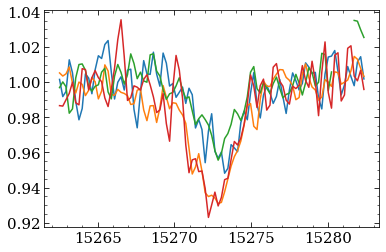

In [ ]:
fig, ax = plt.subplots()
sl = sightlines[0]
for i in range(len(sl.signals)):
    ax.plot(wavs_window, sl.signals[i, :], color = 'C{}'.format(i))
    # ax.plot(wavs_window, sl.signals_aspcap[i, :], color = 'C{}'.format(i), linestyle = 'dashed')

plt.show()

In [ ]:
# sightlines[0]

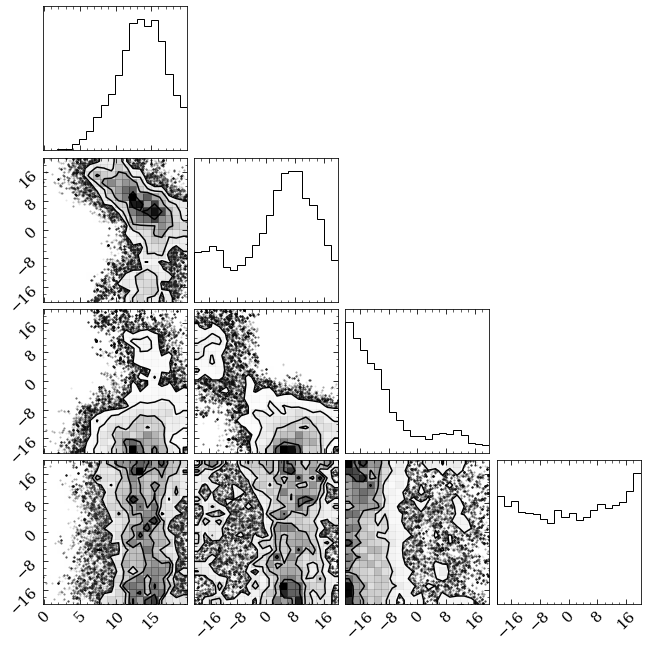

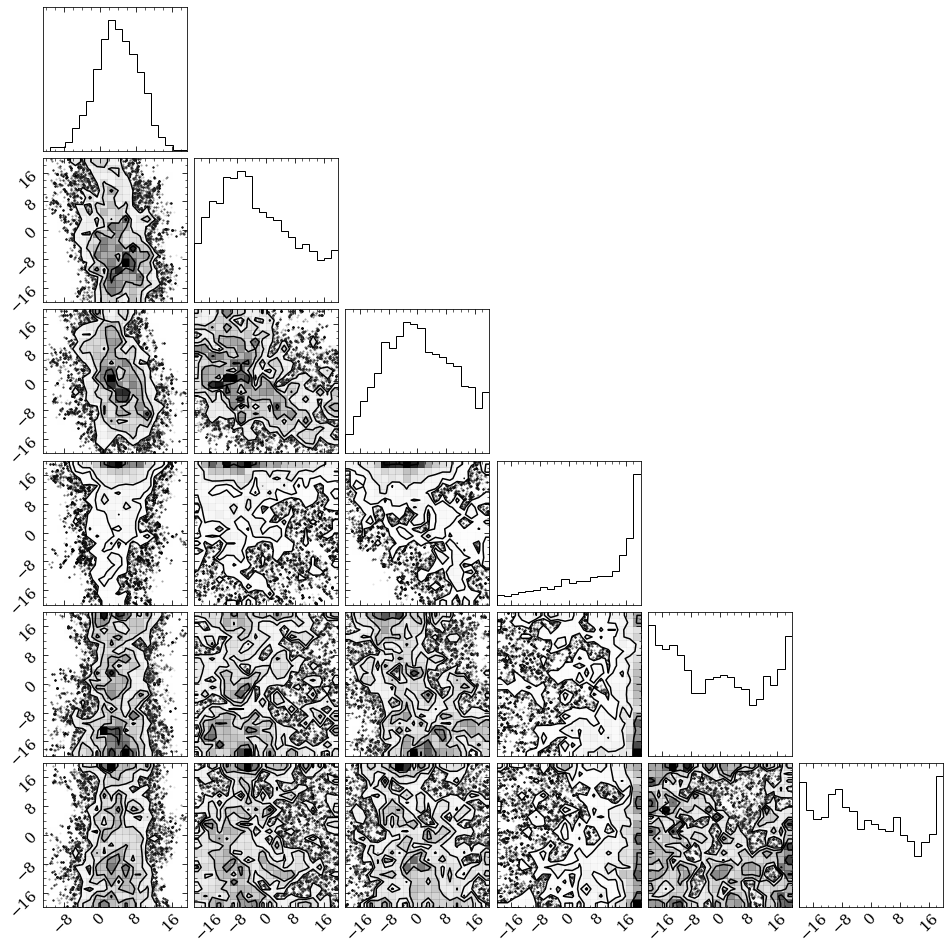

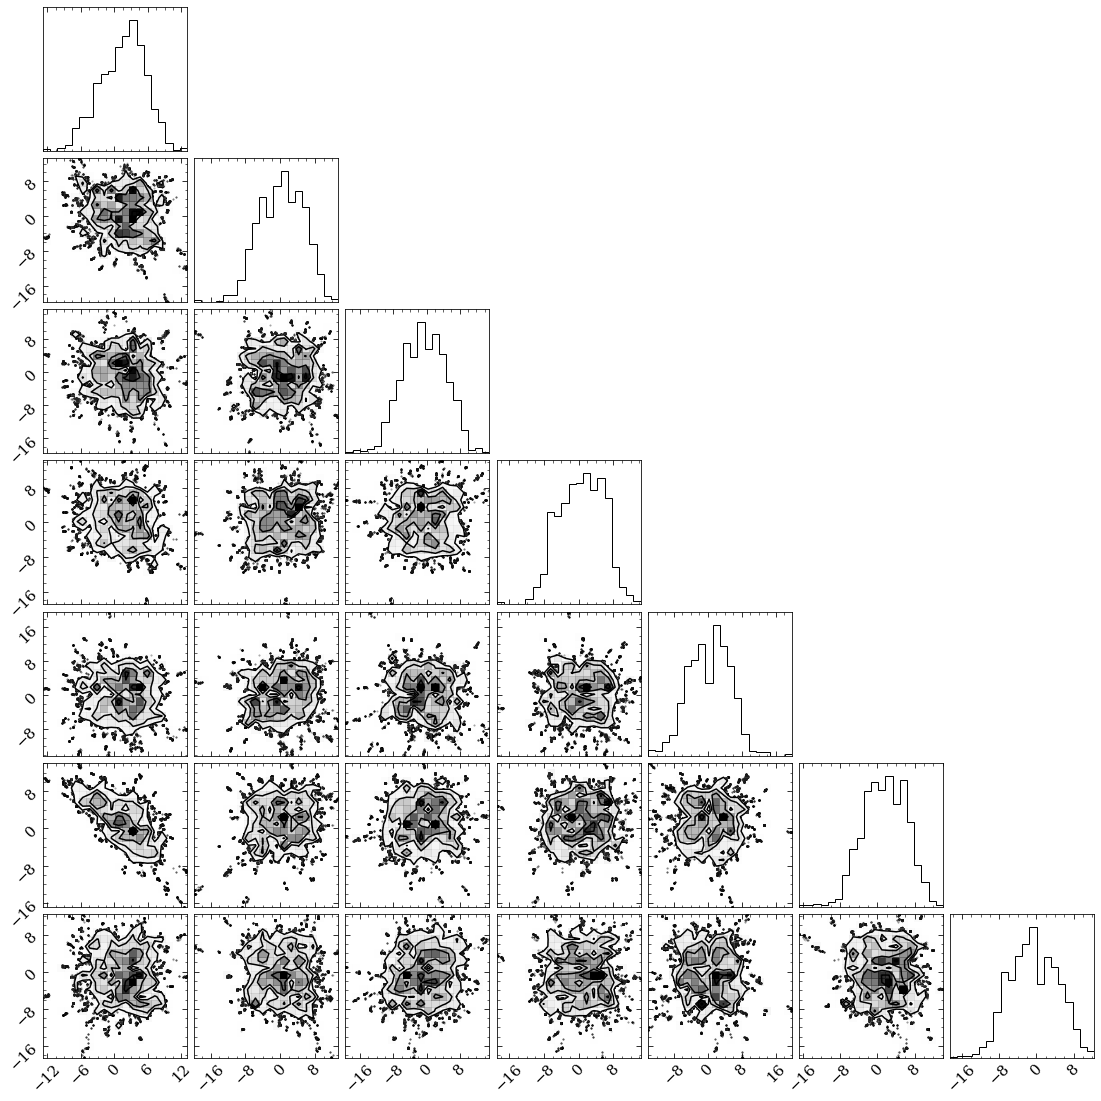

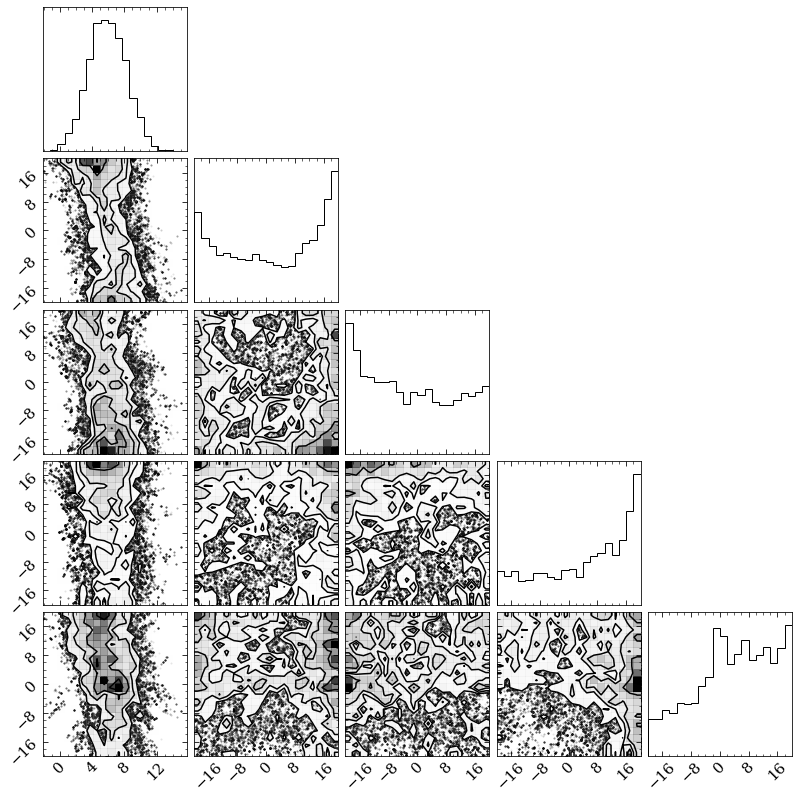

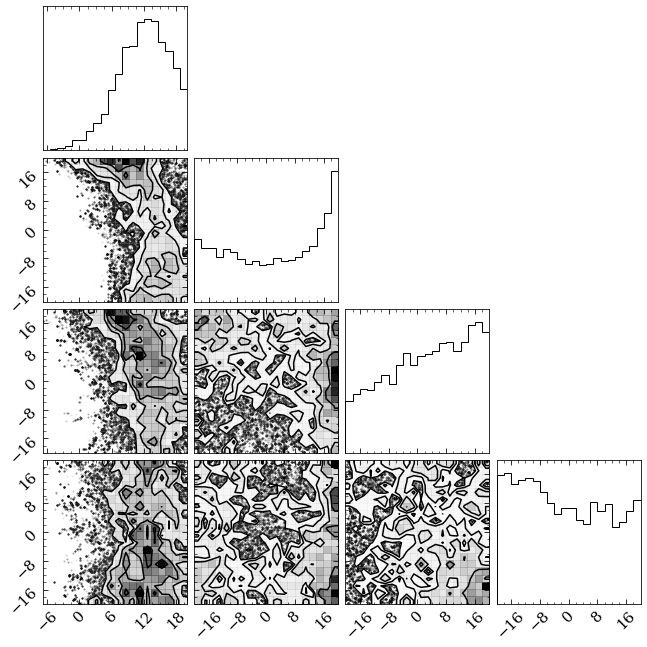

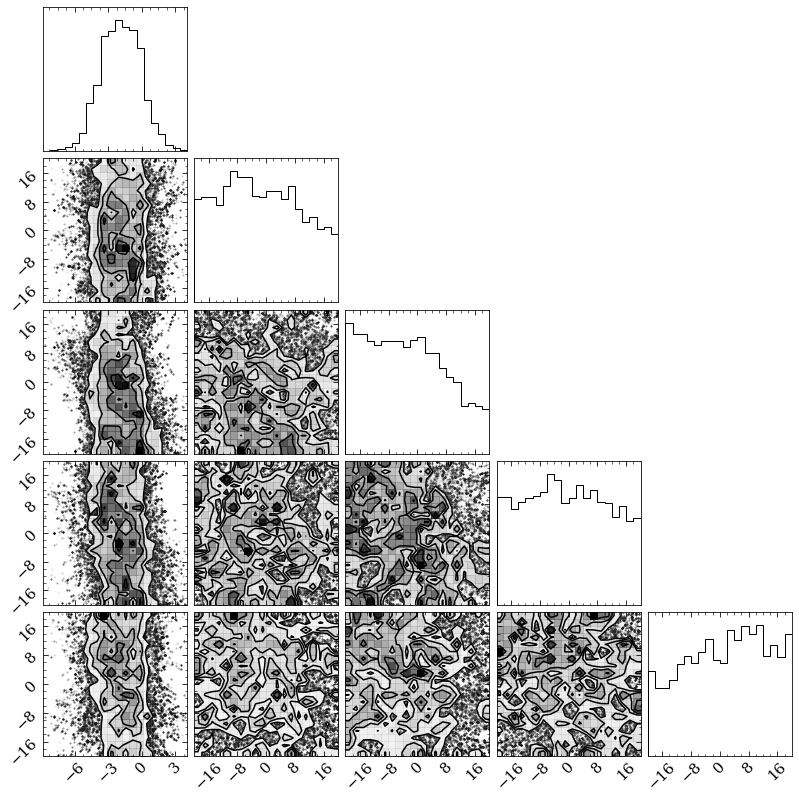

In [ ]:
def make_corner(sampler, labels, minval = 50):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, minval:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

def make_corner_vonly(sampler, ndim, labels, minval = 900):
    samples = sampler.chain[:, minval:, :ndim].reshape((-1, ndim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

if True:
    for i in range(0, len(sightlines), 2):
        sl_i = sightlines[i]
        ndim = len(sl_i.bins) - 1 
        make_corner_vonly(sl_i.sampler, ndim, labels = None)

In [ ]:
sightlines[0].sampler.chain.shape

(500, 1200, 20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(4, 95) (4, 4, 95) (4, 4)


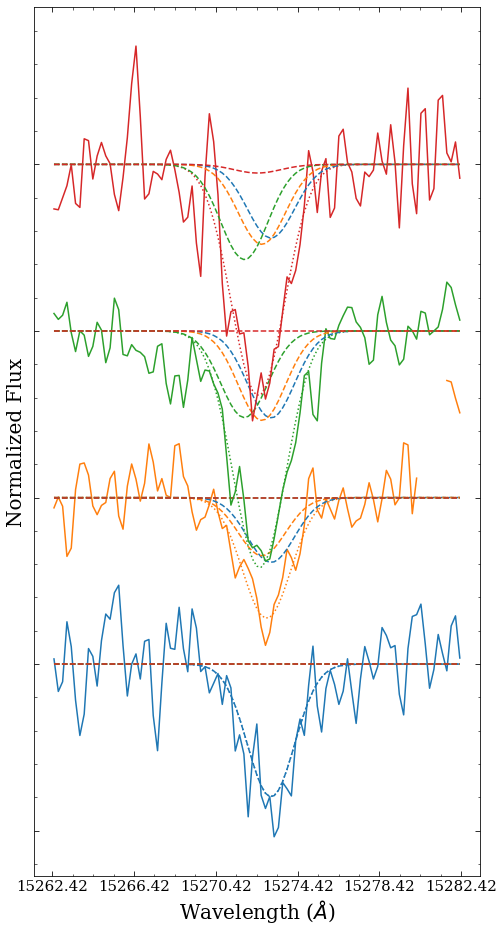

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(4, 95) (4, 4, 95) (4, 4)


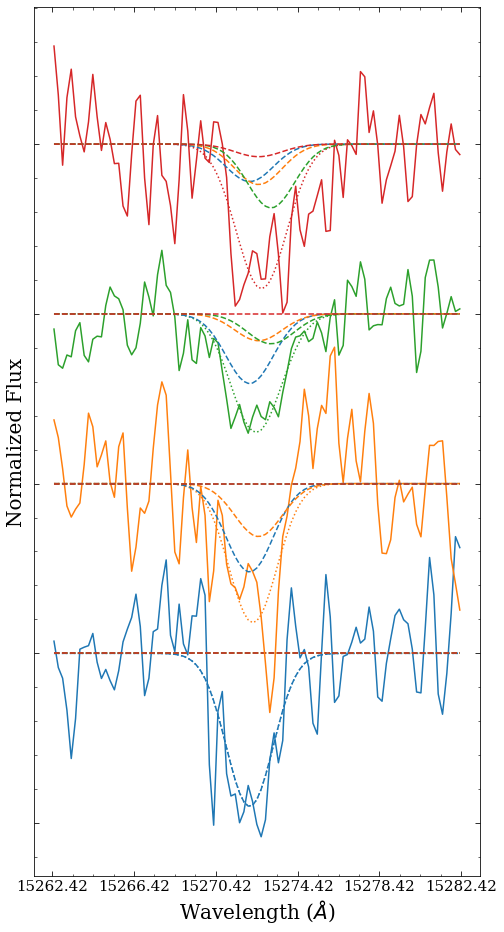

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(6, 95) (6, 6, 95) (6, 6)


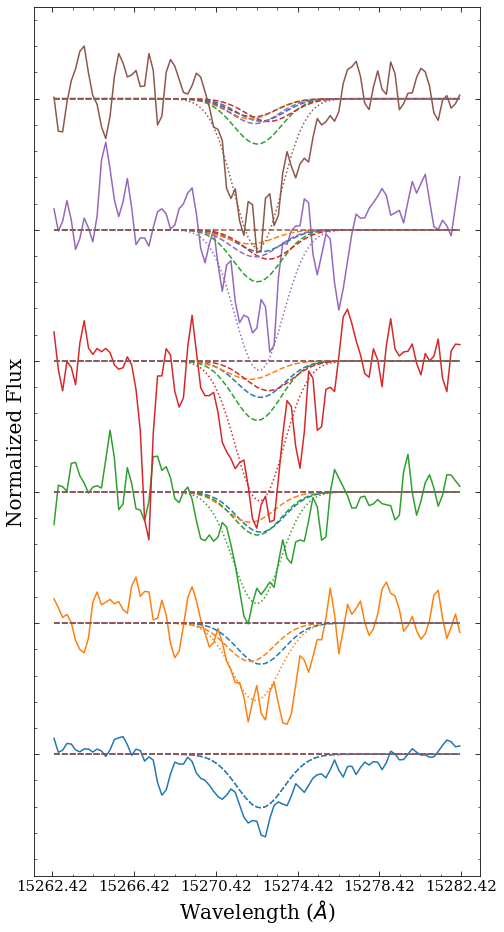

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(7, 95) (7, 7, 95) (7, 7)


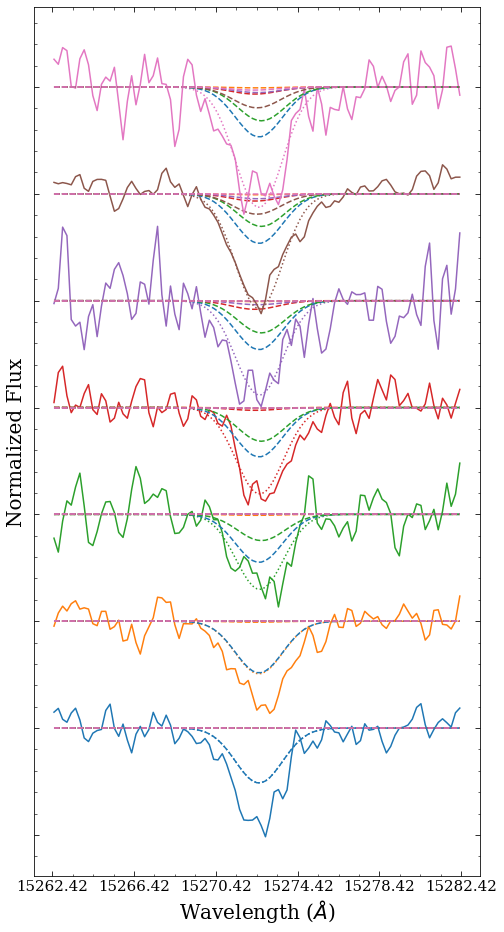

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(7, 95) (7, 7, 95) (7, 7)


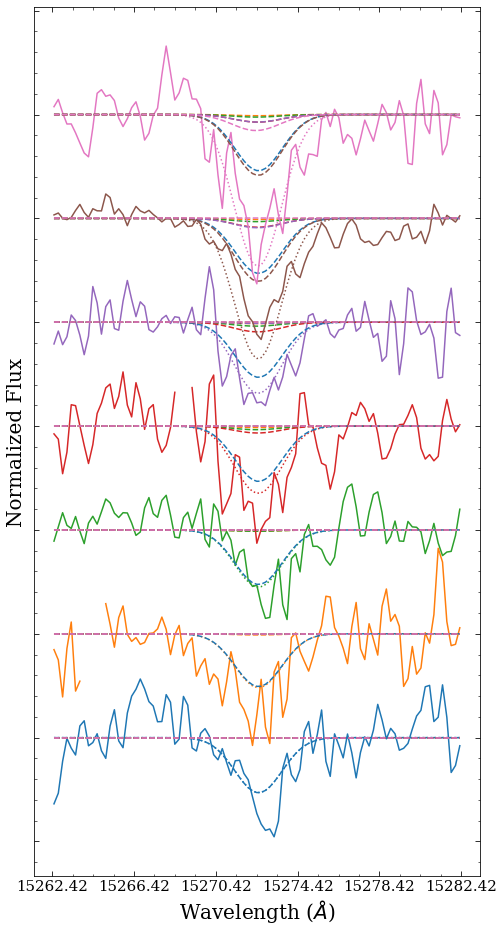

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(6, 95) (6, 6, 95) (6, 6)


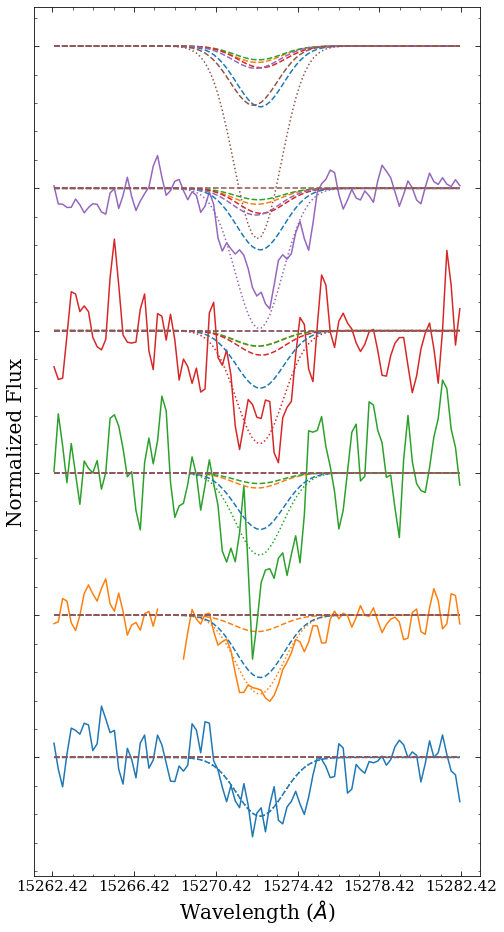

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(5, 95) (5, 5, 95) (5, 5)


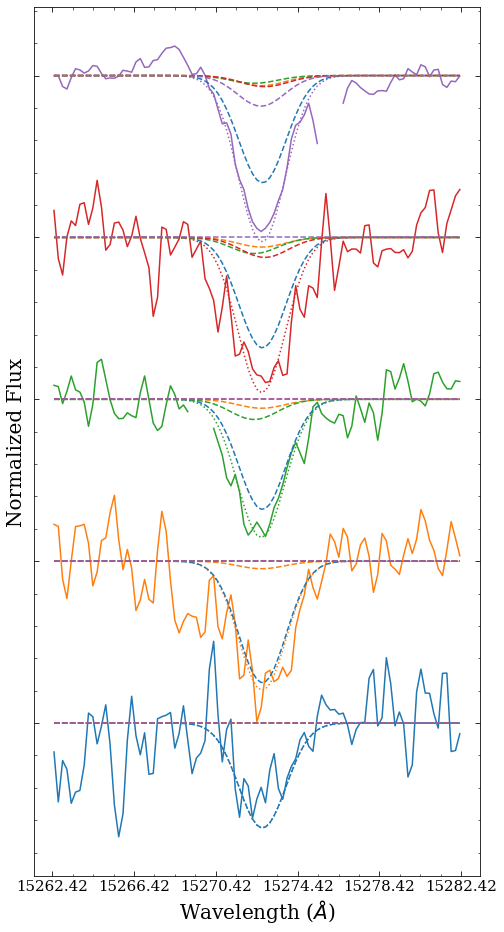

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(4, 95) (4, 4, 95) (4, 4)


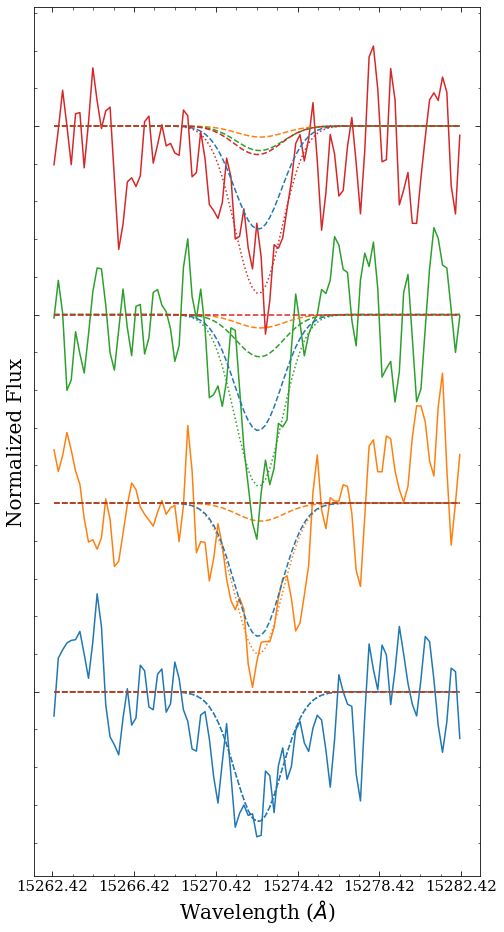

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(4, 95) (4, 4, 95) (4, 4)


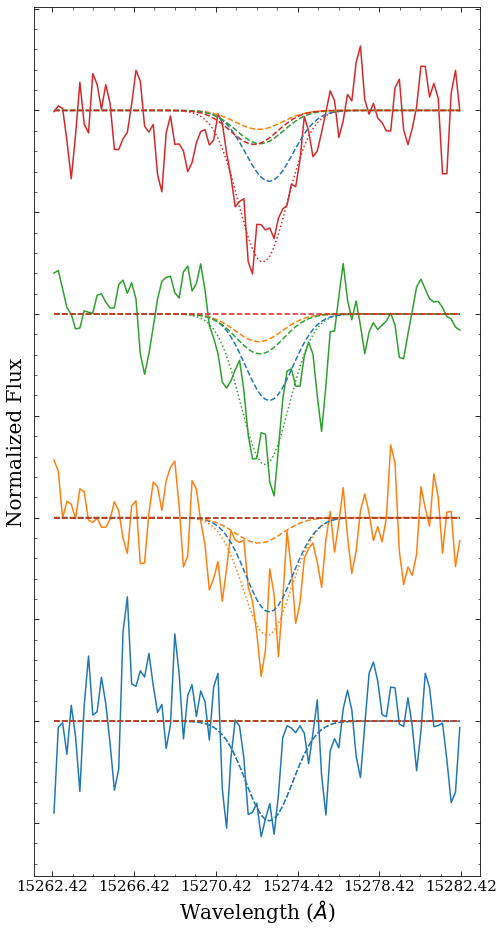

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(5, 95) (5, 5, 95) (5, 5)


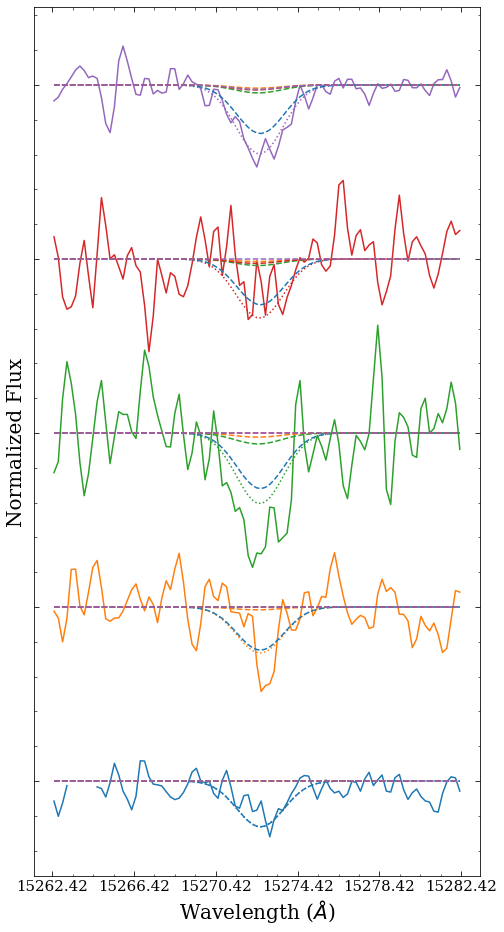

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(5, 95) (5, 5, 95) (5, 5)


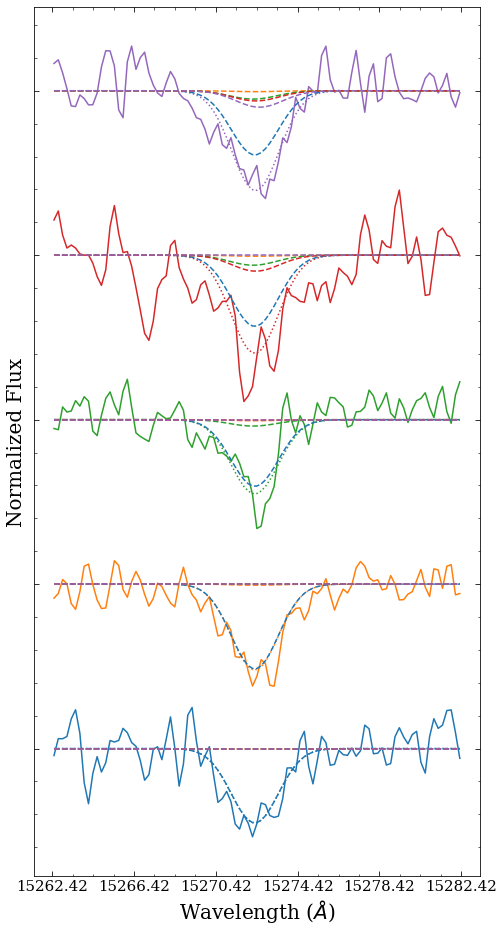

In [ ]:
def model_signals_thing(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    signals = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    print(signals.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = Differential_Amplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):
        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 


    for i in range(len(sl.stars)):
        star = sl.stars[i]
        dAVdd_star = dAVdd[i, :]
        # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
        amp = Differential_Amplitude(dAVdd_star, 1)

        bin_index = sl.bin_inds[i]
        # signals[i, :] = single_signal(bin_index)
        signals[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)

    return signals, unsummed_signals

def plot_DIBS_thing(sampler, sl = sl, plot_objs = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, 500:, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[50:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_yticklabels('')

def plot_DIBS_freeze(sampler, sl = sl, plot_objs = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, 50:, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[50:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_yticklabels('')

for i in range(len(sightlines)):
    fig, ax = plt.subplots(figsize = (8, 16))

    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    plot_DIBS_thing(sampler_i, sl = sl_i, plot_objs = (fig, ax))
    plt.show()


In [ ]:
def plot_velo(sampler, sl  = sl, min_walker = None, plot_objs = None, color = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = 50
    else:
        min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))
    


    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]

    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    # for i in range(len(sl.bins)-1): 
    #     ax.hlines(med_velo[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
    #     if i < len(sl.bins) -2:
    #         ax.vlines(sl.bins[i+1], med_velo[i], med_velo[i+1], linestyle = 'dashed')

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(350, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


In [ ]:
(sl_i.bins[1:] - sl_i.bins[:-1])

array([405.7369  ,  10.01001 ,  25.987366,  23.905243,  59.340637],
      dtype=float32)

In [ ]:
avs = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    avs[i] = np.sum(sl_i.voxel_dAVdd)

cnorm = matplotlib.colors.Normalize(np.min(avs), np.max(avs))
cmap = plt.get_cmap('viridis')
mappable = matplotlib.cm.ScalarMappable(norm = cnorm,  cmap = cmap)


(array([-0.00900642,  5.43806091]), array([[ 3.19745605e-05, -1.00026891e-02],
       [-1.00026891e-02,  3.69698184e+00]]))


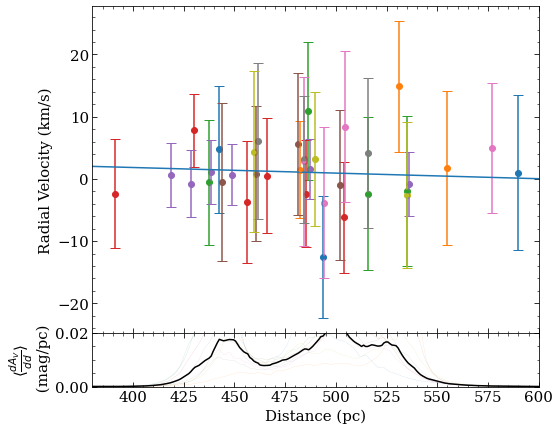

In [ ]:
from scipy.optimize import curve_fit
line = lambda x, m, b : m * x + b

sl_davdd = np.zeros((len(l_sample.flatten()), edenhofer.shape[-1]))
for i in range(len(l_sample.flatten())): 
    l_i, b_i = l_sample.flatten()[i], b_sample.flatten()[i]
    l_ind, b_ind = find_nearest(l_i, b_i)
    sl_davdd[i, :] = np.copy(edenhofer[b_ind, l_ind, :])


fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})


dist_xx = np.array([])
velo_yy = np.array([])
std_velo = np.array([])
# for i in range(22, len(sightlines), 1):
for i in range(N_filament):

    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])
    axs[1].plot(distance, sl_davdd[i, :], linestyle = 'dashed', linewidth = .1, color = 'C{}'.format(i))

dist_sort = np.argsort(dist_xx)


fit_result = curve_fit(line, dist_xx[dist_sort], velo_yy[dist_sort], sigma = std_velo[dist_sort])
print(fit_result)
fit_params = fit_result[0]
fit_result_err = np.sqrt(np.diag(fit_result[1]))
xx_plot = np.linspace(380, 600)

axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]))

# axs[0].fill_between(xx_plot, line(xx_plot, fit_params[0] + fit_result_err[0], fit_params[1] + fit_result_err[1]),
#                     line(xx_plot, fit_params[0] - fit_result_err[0], fit_params[1] - fit_result_err[1]), alpha = 0.1, color = 'C0')

# ymin, ymax = ax.get_ylim()
axs[1].plot(distance, np.nanmedian(sl_davdd[:N_filament, :], axis = 0), color = 'k')
# ax.set_ylim(ymin, ymax)
axs[1].set_ylim(0, 0.02)
axs[1].set_xlim(380, 600)
axs[1].set_xlabel('Distance (pc)')
axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
fig.set_facecolor('white')
# fig.colorbar(mappable, ax = axs[0], label = 'Sightline A(V) (mag)')

# plt.savefig('output_sightlines_{}.png'.format(name), pad_inches = 0.3)
plt.show()

(10,)
(array([ 0.00313742, -1.3585071 ]), array([[ 7.69650304e-05, -1.92865753e-02],
       [-1.92865753e-02,  5.65062028e+00]]))


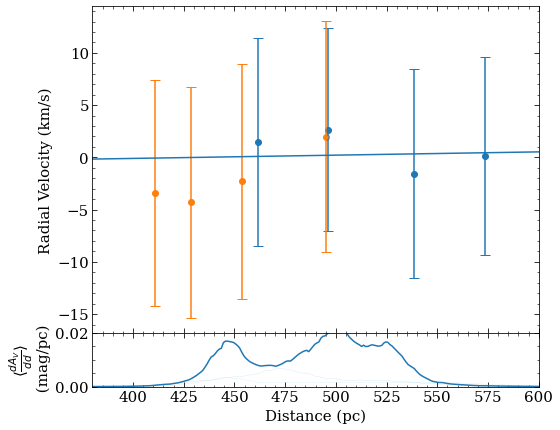

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})


dist_xx = np.array([])
velo_yy = np.array([])
std_velo = np.array([])
for i in range(N_filament, len(sightlines), 1):
    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i - N_filament) 
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])
    axs[1].plot(distance, sl_davdd[i, :], linestyle = 'dashed', linewidth = .1, color = 'C{}'.format(i))


print(dist_xx.shape)
dist_sort = np.argsort(dist_xx)
# dist_sort = np.argsort(dist_xx)[:-8]


fit_result = curve_fit(line, dist_xx[dist_sort], velo_yy[dist_sort], sigma = std_velo[dist_sort])
print(fit_result)
fit_params = fit_result[0]
fit_result_err = np.sqrt(np.diag(fit_result[1]))
xx_plot = np.linspace(380, 600)

axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]))

# axs[0].fill_between(xx_plot, line(xx_plot, fit_params[0] + fit_result_err[0], fit_params[1] + fit_result_err[1]),
#                     line(xx_plot, fit_params[0] - fit_result_err[0], fit_params[1] - fit_result_err[1]), alpha = 0.1, color = 'C0')

# ymin, ymax = ax.get_ylim()
axs[1].plot(distance, np.nanmedian(sl_davdd[N_background:, :], axis = 0) )
axs[1].set_ylim(0, 0.02)

# ax.set_ylim(ymin, ymax)
axs[1].set_xlim(380, 600)
axs[1].set_xlabel('Distance (pc)')
axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
fig.set_facecolor('white')
# fig.colorbar(mappable, ax = axs[0], label = 'Sightline A(V) (mag)')

# plt.savefig('output_sightlines_{}.png'.format(name), pad_inches = 0.3)
plt.show()

In [ ]:
dist_sort

array([5, 0])

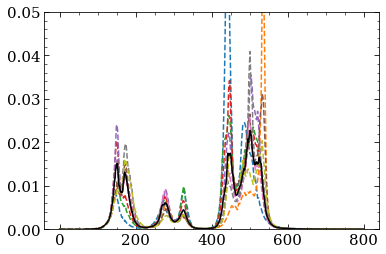

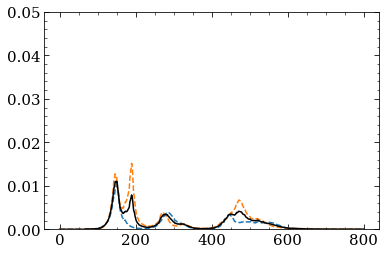

In [ ]:
fig, ax = plt.subplots()
for i in range(N_filament):
    ax.plot(distance, sl_davdd[i, :], linestyle = 'dashed')
ax.plot(distance, np.nanmedian(sl_davdd[:N_filament, : ], axis = 0), color = 'k')
ax.set_ylim(0, 0.05)


plt.show()
fig, ax = plt.subplots()
for i in range(N_filament, N_filament + N_background, 1):
    ax.plot(distance, sl_davdd[i, :], linestyle = 'dashed')

ax.plot(distance, np.nanmedian(sl_davdd[N_filament:, : ], axis = 0), color = 'k')
ax.set_ylim(0, 0.05)

plt.show()

[216.82496643 442.28741455 493.67572021 589.63739014]
[ 13.63787997   4.7693526  -12.5137095    0.99679148]
[442.28741455 493.67572021 589.63739014]
(array([-0.01595536,  4.99475699]), array([[ 1.90292556e-02, -9.48720230e+00],
       [-9.48720230e+00,  4.79049758e+03]]))


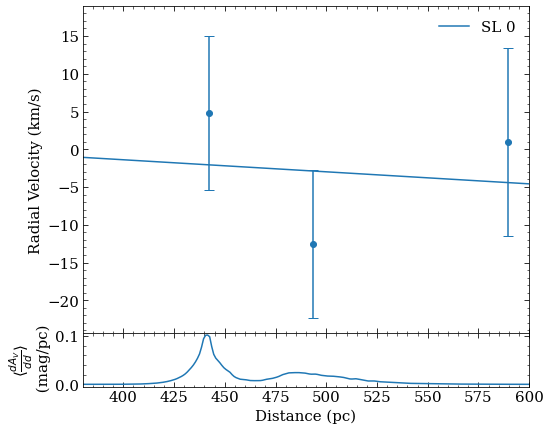

[223.84165955 482.16241455 531.13171387 554.56182861]
[-6.8924727   1.49289578 14.87539165  1.75493242]
[482.16241455 531.13171387 554.56182861]
(array([  0.08690724, -39.03863073]), array([[ 3.13122290e-02, -1.59850342e+01],
       [-1.59850342e+01,  8.18937646e+03]]))


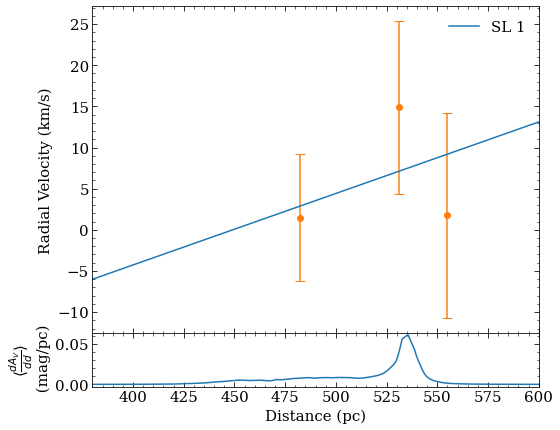

[125.85613251 327.66207886 437.30133057 486.15039062 515.6151123
 534.92529297]
[ 3.87805748 -2.95091217 -0.57373968 10.87704692 -2.3519286  -1.91612773]
[437.30133057 486.15039062 515.6151123  534.92529297]
(array([-0.01990914, 11.42096454]), array([[ 1.00619060e-02, -4.90688015e+00],
       [-4.90688015e+00,  2.40747568e+03]]))


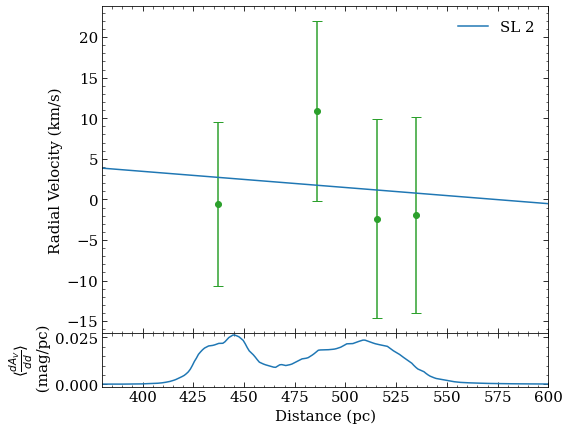

[187.08995056 391.30517578 429.85888672 456.29232788 466.30233765
 485.25415039 504.20599365]
[ 2.08192947 -2.38305314  7.80312904 -3.71278819  0.5130661  -2.34930439
 -6.19657115]
[391.30517578 429.85888672 456.29232788 466.30233765 485.25415039
 504.20599365]
(array([-0.07311138, 33.57316798]), array([[ 4.20816215e-03, -1.89671010e+00],
       [-1.89671010e+00,  8.60191001e+02]]))


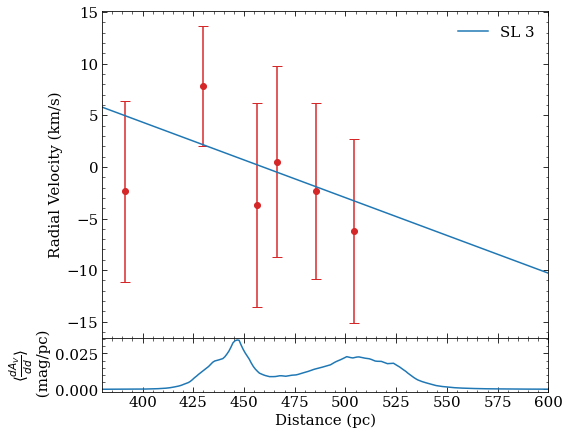

[206.80059814 418.60620117 428.61621094 438.6262207  448.63623047
 487.24285889 536.24688721]
[ 1.892843    0.613835   -0.74181903  1.14352042  0.71044035  1.53604576
 -0.8286006 ]
[418.60620117 428.61621094 438.6262207  448.63623047 487.24285889
 536.24688721]
(array([-0.00553072,  3.00613136]), array([[ 1.15220973e-04, -5.30659964e-02],
       [-5.30659964e-02,  2.46247974e+01]]))


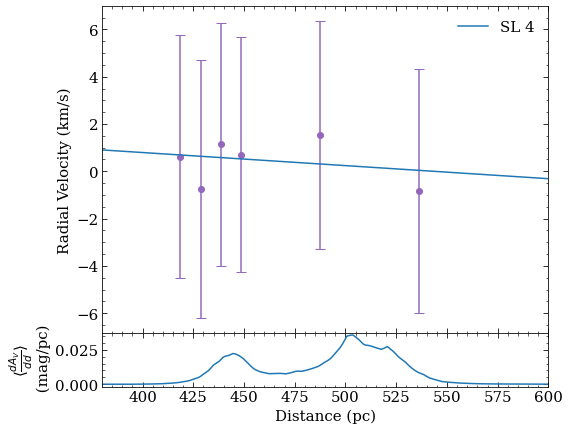

[217.67939758 443.95129395 460.6541748  481.24609375 501.97814941
 716.83312988]
[ 3.33143708 -0.47193241  0.80576723  5.66203417 -1.01785962 -3.57696951]
[443.95129395 460.6541748  481.24609375 501.97814941]
(array([ 0.01434999, -5.40072771]), array([[ 7.85720856e-03, -3.71068931e+00],
       [-3.71068931e+00,  1.75587688e+03]]))


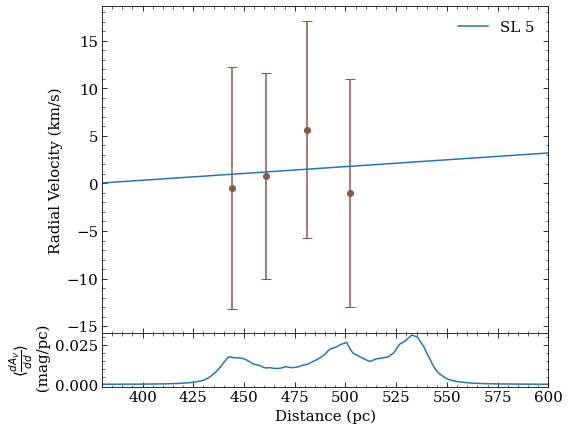

[239.69009399 484.38519287 494.39520264 504.4052124  577.1652832 ]
[ 5.90164588  2.84051909 -3.83002617  8.39255459  4.96789442]
[484.38519287 494.39520264 504.4052124  577.1652832 ]
(array([  0.03876654, -16.96179317]), array([[ 5.62144440e-03, -2.93406789e+00],
       [-2.93406789e+00,  1.53997804e+03]]))


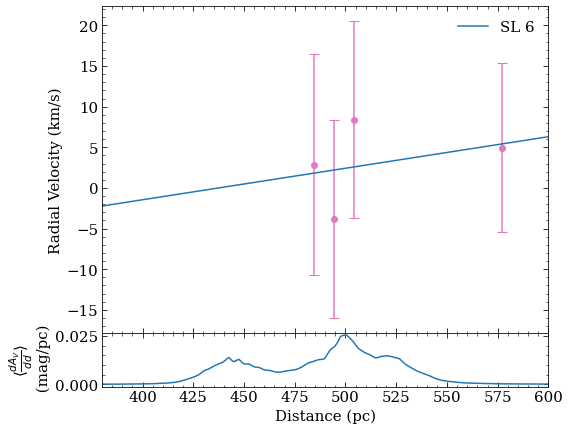

[227.1725769  461.42932129 484.21801758 515.96722412]
[1.3844544  6.16720362 3.15865507 4.16010587]
[461.42932129 484.21801758 515.96722412]
(array([-0.03025664, 19.04670151]), array([[ 2.57831903e-03, -1.25656653e+00],
       [-1.25656653e+00,  6.13527255e+02]]))


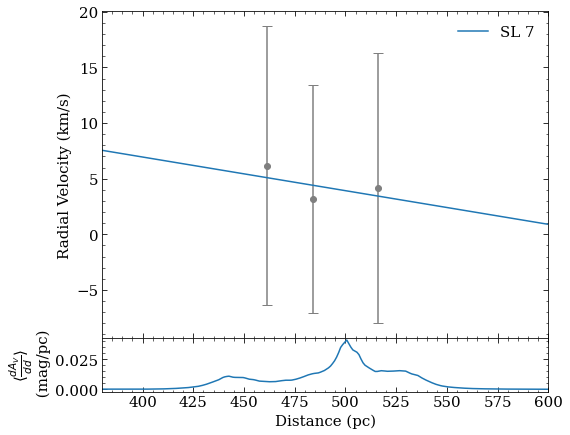

[225.64433289 459.79754639 489.87664795 535.07519531]
[11.48536912  4.34916698  3.24826992 -2.60471977]
[459.79754639 489.87664795 535.07519531]
(array([-0.09744176, 50.00076638]), array([[ 7.38424631e-04, -3.66710790e-01],
       [-3.66710790e-01,  1.82762802e+02]]))


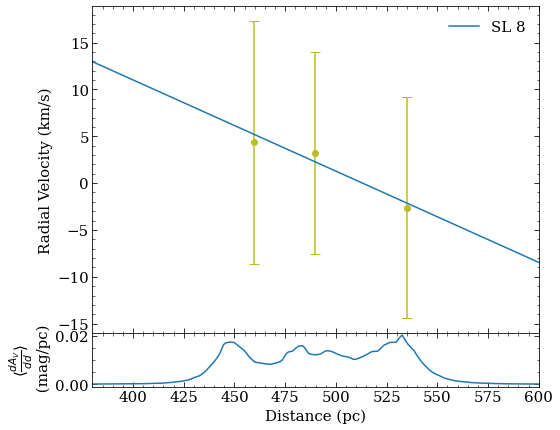

[227.1526947  461.76708984 496.18115234 538.65112305 573.41540527]
[ 4.60455302  1.47122506  2.66427202 -1.56663443  0.11669033]
[461.76708984 496.18115234 538.65112305 573.41540527]
(array([-0.02276178, 12.49644408]), array([[ 4.14866653e-04, -2.15133561e-01],
       [-2.15133561e-01,  1.12308937e+02]]))


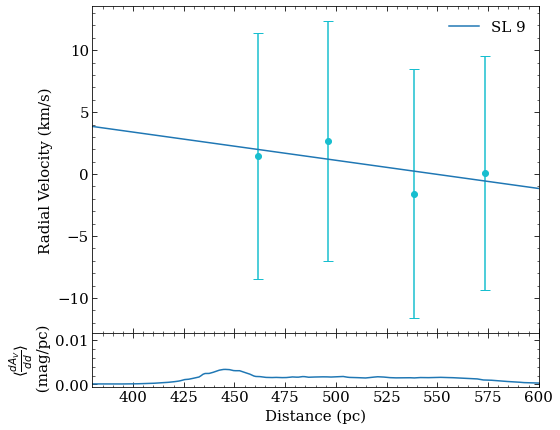

[202.86845398 410.74191284 428.74060059 453.68688965 495.30984497]
[-1.89811868 -3.42001755 -4.28479662 -2.30742894  1.97086845]
[410.74191284 428.74060059 453.68688965 495.30984497]
(array([  0.06982166, -33.20719107]), array([[ 3.97306409e-04, -1.77439138e-01],
       [-1.77439138e-01,  7.96504741e+01]]))


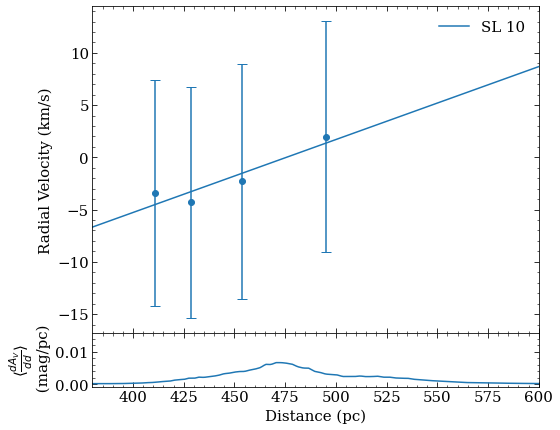

In [ ]:
sightlines_slopes = np.zeros(len(sightlines))
sightlines_slopes_err = np.zeros(len(sightlines))
for i in range(len(sightlines)): 
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})


    dist_xx = np.array([])
    velo_yy = np.array([])
    std_velo = np.array([])
    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])

    print(dist_xx)
    print(velo_yy)

    dist_sort = np.argsort(dist_xx)
    # print(dist_sort)

    try:
        filt = (dist_xx[dist_sort] >= 380) & (dist_xx[dist_sort] <= 600)
        print(dist_xx[dist_sort][filt])
        fit_result = curve_fit(line, dist_xx[dist_sort][filt], velo_yy[dist_sort][filt], sigma = std_velo[dist_sort][filt])
        print(fit_result)
        fit_params = fit_result[0]
        fit_result_err = np.sqrt(np.diag(fit_result[1]))
        xx_plot = np.linspace(380, 600)

        axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]), label = 'SL ' + str(i))
        sightlines_slopes[i] = fit_params[0] 
        sightlines_slopes_err[i] = fit_result_err[0]
    except Exception as e:
        print('didn\'t fit properly')
        print(e)
        sightlines_slopes[i] = np.nan

    # axs[0].fill_between(xx_plot, line(xx_plot, fit_params[0] + fit_result_err[0], fit_params[1] + fit_result_err[1]),
    #                     line(xx_plot, fit_params[0] - fit_result_err[0], fit_params[1] - fit_result_err[1]), alpha = 0.1, color = 'C0')

    # ymin, ymax = ax.get_ylim()
    axs[1].plot(distance, sl_davdd[i, :])
    # ax.set_ylim(ymin, ymax)
    axs[1].set_xlim(380, 600)
    axs[1].set_xlabel('Distance (pc)')
    axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
    fig.set_facecolor('white')
    # fig.colorbar(mappable, ax = axs[0], label = 'Sightline A(V) (mag)')
    axs[0].legend()

    # plt.savefig('output_sightlines_{}.png'.format(name), pad_inches = 0.3)
    plt.show()

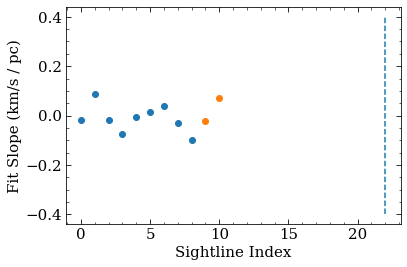

In [ ]:
fig, ax = plt.subplots()
ax.scatter(np.arange(N_filament), sightlines_slopes[:N_filament], label = 'Filament')
ax.scatter(np.arange(N_filament, N_filament + N_background), sightlines_slopes[N_filament:], label = 'Off Filament')
ax.plot((22, 22), (-0.4, 0.4), linestyle = 'dashed')
ax.set_xlabel('Sightline Index')
ax.set_ylabel('Fit Slope (km/s / pc)')

mean1, std1 = (np.nanmean(sightlines_slopes[:N_filament]), np.nanstd(sightlines_slopes[:N_filament], ddof = 1))
mean2, std2 = (np.nanmean(sightlines_slopes[N_filament:]), np.nanstd(sightlines_slopes[N_filament:], ddof = 1))

# ax.errorbar((22-0)/2 + 0, mean1, yerr = std1, c= 'k', capsize = 2, fmt = 'o')
# ax.errorbar((48-22)/2 + 22, mean2, yerr = std2, c= 'k', capsize = 2, fmt = 'o')

fig.set_facecolor('white')
plt.show()

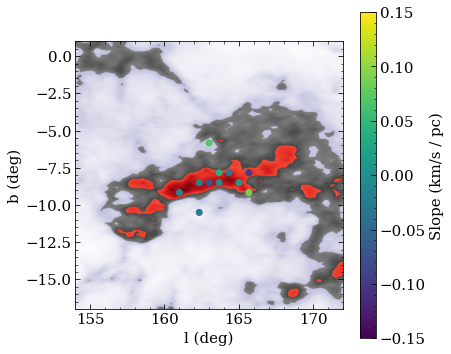

In [ ]:
fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (l0-9, l0+9, b0-9, b0+9))
masks = (np.nansum(edenhofer, axis = 2) >= 2.2).astype(float)
masks_3 = (np.nansum(edenhofer, axis = 2) < 1.5).astype(float)
im_mask = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Reds', alpha = masks, extent = (l0-9, l0+9, b0-9, b0+9))
im_mask_3 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Purples', alpha = masks_3, extent = (l0-9, l0+9, b0-9, b0+9))
points = ax.scatter(l_sample[:], b_sample[:], c = sightlines_slopes[:], vmin = -0.15, vmax = 0.15)
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Slope (km/s / pc)')
plt.show()

